# 示例_使用**<font color=#B22222>Scorecard-Bundle<font>**进行基本的评分卡建模

<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据准备" data-toc-modified-id="数据准备-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据准备</a></span><ul class="toc-item"><li><span><a href="#下载样例数据" data-toc-modified-id="下载样例数据-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>下载样例数据</a></span></li><li><span><a href="#处理分类型变量及缺失值" data-toc-modified-id="处理分类型变量及缺失值-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>处理分类型变量及缺失值</a></span></li><li><span><a href="#定义特征和建模目标" data-toc-modified-id="定义特征和建模目标-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>定义特征和建模目标</a></span></li></ul></li><li><span><a href="#评分卡模型" data-toc-modified-id="评分卡模型-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>评分卡模型</a></span><ul class="toc-item"><li><span><a href="#特征离散化（基于ChiMerge）" data-toc-modified-id="特征离散化（基于ChiMerge）-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>特征离散化（基于ChiMerge）</a></span></li><li><span><a href="#特征编码（基于证据权重WOE）" data-toc-modified-id="特征编码（基于证据权重WOE）-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>特征编码（基于证据权重WOE）</a></span></li><li><span><a href="#特征选择" data-toc-modified-id="特征选择-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>特征选择</a></span></li><li><span><a href="#模型训练" data-toc-modified-id="模型训练-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>模型训练</a></span></li><li><span><a href="#模型评估" data-toc-modified-id="模型评估-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>模型评估</a></span></li></ul></li></ul></div>

## 数据准备

### 下载样例数据

In [1]:
# The folowing codes for downloading housing price dataset is from 
# Aurélien Géron's book "Hands on Machine Learning with Scikit-learn and Tensorflow"
import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()

In [2]:
housing = load_housing_data()
print(housing.columns)
print('shape:',housing.shape)
housing.head()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 处理分类型变量及缺失值

In [3]:
housing.drop(['ocean_proximity'], axis=1, inplace=True) # 为了简便，去除分类型变量

In [4]:
housing.isna().sum() # 查看缺失情况

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [5]:
housing.fillna(value=housing.total_bedrooms.median(), inplace=True) # 为了简便，将缺失的total_bedrooms赋值为其中位数

### 定义特征和建模目标

- 设`median_house_value`为目标，其他列为特征；


- 为了简便，不区分训练集和测试集合；


- 设`median_house_value`大于其90%分位数时y=1，否则y=0;

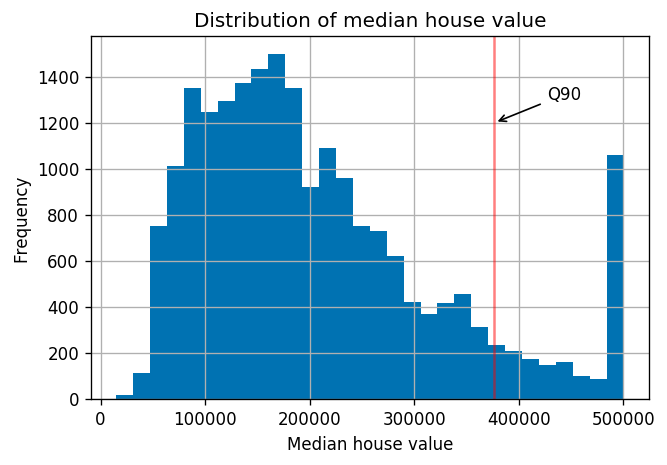

In [6]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind') # Set style for matplotlib
plt.rcParams['savefig.dpi'] = 300 # dpi of diagrams
plt.rcParams['figure.dpi'] = 120

housing.median_house_value.hist(bins=30)
plt.axvline(x=housing.median_house_value.quantile(0.9), c='r', alpha=0.5)
plt.annotate(s='Q90',xy=(housing.median_house_value.quantile(0.9),1200),
            xytext=(housing.median_house_value.quantile(0.9)+50000,1300),
            arrowprops={'arrowstyle':'->'})
plt.title('Distribution of median house value')
plt.ylabel('Frequency')
plt.xlabel('Median house value')
plt.show()

In [7]:
features = list(set(housing.columns) - set(['median_house_value'])) # feature name list
q90 = housing.median_house_value.quantile(0.9)
X, y = housing[features], housing.median_house_value.map(lambda x: 1 if x>q90 else 0)

## 评分卡模型

In [8]:
import sys
sys.path.append('E:\Github\Scorecard-Bundle')
from scorecardbundle.feature_discretization import ChiMerge as cm
from scorecardbundle.feature_encoding import WOE as woe
from scorecardbundle.model_training import LogisticRegressionScoreCard as lrsc
from scorecardbundle.model_evaluation import ModelEvaluation as me

### 特征离散化（基于ChiMerge）

In [9]:
trans_cm = cm.ChiMerge(max_intervals=5, min_intervals=2, output_dataframe=True)
result_cm = trans_cm.fit_transform(X, y) # ChiMerge运行较慢. 在20,000个样本、8个特征上训练约需10分钟 
result_cm.head()

,longitude,latitude,population,total_bedrooms,total_rooms,households,housing_median_age,median_income
0,-122.62~-121.58000000000001,37.6~37.99,-inf~873.0,-inf~335.0,319.0~1176.0,-inf~248.0,36.0~51.0,7.7197~inf
1,-122.62~-121.58000000000001,37.6~37.99,1529.0~3570.0,685.0~2216.270000000004,2657.0~inf,853.0~1257.4399999999987,19.0~36.0,7.7197~inf
2,-122.62~-121.58000000000001,37.6~37.99,-inf~873.0,-inf~335.0,1176.0~2012.0,-inf~248.0,51.0~52.0,5.753465~7.7197
3,-122.62~-121.58000000000001,37.6~37.99,-inf~873.0,-inf~335.0,1176.0~2012.0,-inf~248.0,51.0~52.0,3.9669399999999992~5.753465
4,-122.62~-121.58000000000001,37.6~37.99,-inf~873.0,-inf~335.0,1176.0~2012.0,248.0~260.0,51.0~52.0,3.0083~3.9669399999999992


In [11]:
trans_cm.boundaries_ # 每个特征的区间切分

{'households': array([ 248.  ,  260.  ,  853.  , 1257.44,     inf]),
 'housing_median_age': array([ 9., 19., 36., 51., 52.]),
 'latitude': array([34.49, 36.97, 37.6 , 37.99,   inf]),
 'longitude': array([-122.62, -121.58, -118.98, -118.37,     inf]),
 'median_income': array([3.0083  , 3.96694 , 5.753465, 7.7197  ,      inf]),
 'population': array([ 873.,  992., 1529., 3570.,   inf]),
 'total_bedrooms': array([ 335.  ,  341.  ,  685.  , 2216.27,     inf]),
 'total_rooms': array([ 319., 1176., 2012., 2657.,   inf])}

### 特征编码（基于证据权重WOE）

In [12]:
trans_woe = woe.WOE_Encoder(output_dataframe=True)
result_woe = trans_woe.fit_transform(result_cm, y) # WOE运行很快，此任务仅需1秒
result_woe.head()

,longitude,latitude,population,total_bedrooms,total_rooms,households,housing_median_age,median_income
0,0.54122,0.304771,0.322442,0.053637,-0.695164,0.018522,0.123922,3.808660
1,0.54122,0.304771,-0.325632,0.090923,0.314325,0.237510,-0.033261,3.808660
2,0.54122,0.304771,0.322442,0.053637,-0.234270,0.018522,1.127234,1.295348
3,0.54122,0.304771,0.322442,0.053637,-0.234270,0.018522,1.127234,-0.075948
4,0.54122,0.304771,0.322442,0.053637,-0.234270,0.442561,1.127234,-0.870713


In [13]:
trans_woe.iv_ # 每个特征的信息值 (iv) 

{'households': 0.0135796280489273,
 'housing_median_age': 0.19060315707077985,
 'latitude': 0.7183847080349024,
 'longitude': 0.7654090245162248,
 'median_income': 2.3397193770128966,
 'population': 0.08695555095576324,
 'total_bedrooms': 0.013541575632127906,
 'total_rooms': 0.10662402115734344}

In [14]:
trans_woe.result_dict_ # 每个特征的WOE字典和信息值 (iv) 

{'households': ({'-inf~248.0': 0.01852150817161554,
   '1257.4399999999987~inf': -0.3136703825650484,
   '248.0~260.0': 0.4425611479893831,
   '260.0~853.0': -0.032828802944417854,
   '853.0~1257.4399999999987': 0.2375099970837297},
  0.0135796280489273),
 'housing_median_age': ({'-inf~9.0': -0.23835346407206823,
   '19.0~36.0': -0.03326078999759868,
   '36.0~51.0': 0.12392224123497612,
   '51.0~52.0': 1.1272337015266705,
   '9.0~19.0': -0.607474853400939},
  0.19060315707077985),
 'latitude': ({'-inf~34.49': 0.14396913031389935,
   '34.49~36.97': -1.7569264297479703,
   '36.97~37.6': 0.931717788490672,
   '37.6~37.99': 0.3047708625525933,
   '37.99~inf': -2.7389973720452145},
  0.7183847080349024),
 'longitude': ({'-118.37~inf': -0.3775625638820992,
   '-118.97999999999999~-118.37': 1.3515459501394256,
   '-121.58000000000001~-118.97999999999999': -1.6298897437321815,
   '-122.62~-121.58000000000001': 0.5412198652392345,
   '-inf~-122.62': -2.6289494331299},
  0.7654090245162248),
 'm

### 特征选择

- 特征选择是评分卡建模的***关键步骤***，应至少去除预测力过小的特征（如iv<0.02）并处理共线性问题（例如使用皮尔森相关系数或方差膨胀因子）；


- 上述特征筛选尚未在Scorecard-Bundle中部署，但用户可参考如下思路轻松实现：
    - 预测力筛选：从`WOE_Encoder`的`iv_`属性中得到特征的信息值；
    - 共线性筛选：在经WOE编码的特征数据上使用`pandas.DataFrame.corr()`，识别相关性较强的特征对（例如corr>0.7）,并去除每对特征中的一个（例如预测力弱的那个）；
    
    
- 特征选择模块将在Scorecard-Bundle的2.0版本中部署，同时将增添评价特征可解释性的算法；

### 模型训练

In [15]:
model = lrsc.LogisticRegressionScoreCard(trans_woe, PDO=-20, basePoints=100, verbose=True)
model.fit(result_woe, y)

从`woe_df_`属性中可得评分卡规则。

In [16]:
model.woe_df_

,feature,value,woe,beta,score
0,longitude,-118.37~inf,-0.377563,0.631033,5.0
1,longitude,-118.97999999999999~-118.37,1.351546,0.631033,37.0
2,longitude,-121.58000000000001~-118.97999999999999,-1.629890,0.631033,-17.0
3,longitude,-122.62~-121.58000000000001,0.541220,0.631033,22.0
4,longitude,-inf~-122.62,-2.628949,0.631033,-36.0
5,latitude,-inf~34.49,0.143969,0.463244,14.0
6,latitude,34.49~36.97,-1.756926,0.463244,-11.0
7,latitude,36.97~37.6,0.931718,0.463244,25.0
8,latitude,37.6~37.99,0.304771,0.463244,16.0
9,latitude,37.99~inf,-2.738997,0.463244,-24.0


评分卡应该应用在初始的特征上（即未经离散化和WOE编码的特征数据）。

In [17]:
result = model.predict(X) # Scorecard should be applied on the original feature values
result.head() # if model object's verbose parameter is set to False, predict will only return Total scores

,longitude,latitude,population,total_bedrooms,total_rooms,households,housing_median_age,median_income,TotalScore
0,22.0,16.0,35.0,14.0,-34.0,13.0,17.0,115.0,198.0
1,22.0,16.0,-11.0,16.0,33.0,16.0,11.0,115.0,218.0
2,22.0,16.0,35.0,14.0,-4.0,13.0,53.0,47.0,196.0
3,22.0,16.0,35.0,14.0,-4.0,13.0,53.0,10.0,159.0
4,22.0,16.0,35.0,14.0,-4.0,19.0,53.0,-11.0,144.0


### 模型评估

KS = 0.652


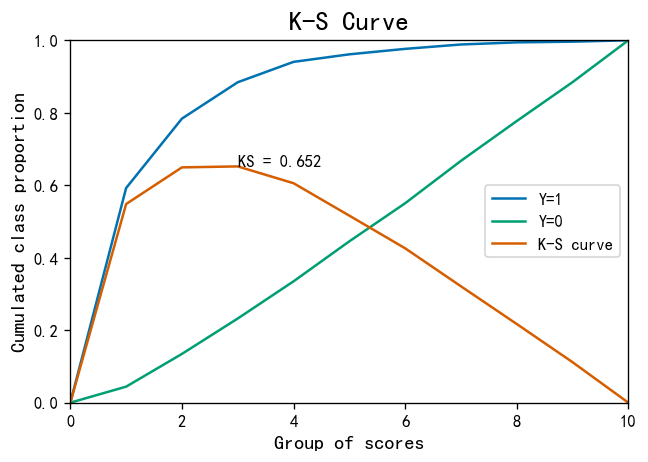

AUC: 0.9126749595837904


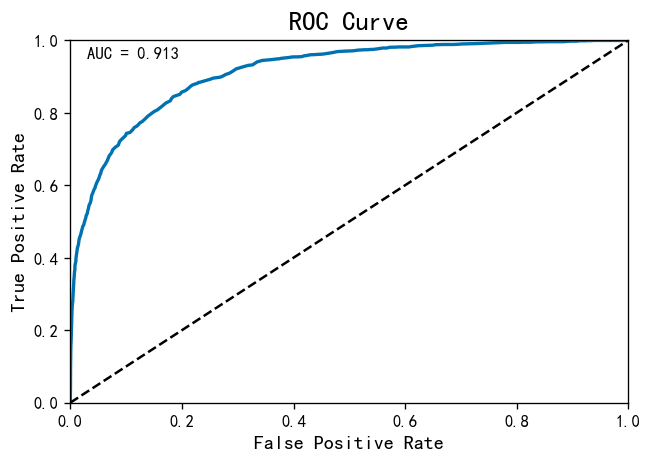

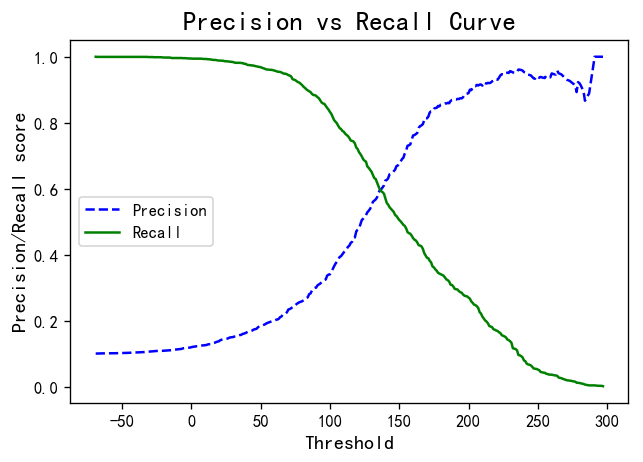

In [18]:
me.plot_all(y, result['TotalScore'])